# LeNet-5 Implementation

## Imports

In [20]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as F

In [21]:
from baseSetterHelper import setAllSeeds, setDeterministic, computeAccu, computeConfusionMatrix
from trainerHelper import modelTrainer
from plottingHelper import plotTrainingLoss, plotAccuracy, show_examples, plotConfusionMat
from dataLoaderHelper import getDataLoadersMNIST

## Settings and DataSet

In [22]:
##########
##Settings
##########

numEpochs = 10
batchSize = 256
randomSeed = 123
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [23]:
setAllSeeds(randomSeed)

In [24]:
resizeTransforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32,32)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,),(0.5,))
])

In [25]:
trainLoader, valLoader, testLoader = getDataLoadersMNIST(batchSize=batchSize, validFraction=0.1, trainTransforms=resizeTransforms, testTransforms=resizeTransforms)


In [26]:
for images, labels in trainLoader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

Image batch dimensions: torch.Size([256, 1, 32, 32])
Image label dimensions: torch.Size([256])
Class labels of 10 examples: tensor([4, 5, 8, 9, 9, 4, 9, 9, 3, 9])


## LeNet Class

In [27]:
class LeNet(F.Module):
  def __init__(self,numClasses,type_='gS'):
    super().__init__()
    self.Type = type_
    self.numClasses = numClasses

    if(type_ =='cS'):
      inChannels = 3
    else:
      inChannels = 1

    self.features = F.Sequential(
        F.Conv2d(inChannels,6,kernel_size=5), #28*28*6
        F.Tanh(),
        F.MaxPool2d(kernel_size=2), #14*14*6
        F.Conv2d(6,16,kernel_size=5), #10*10*16
        F.Tanh(),
        F.MaxPool2d(kernel_size=2) #5*5*16
    )

    self.Classifier = F.Sequential(
        F.Linear(5*5*16,120),
        F.Tanh(),
        F.Linear(120,84),
        F.Tanh(),
        F.Linear(84,numClasses)
    )

  def forward(self,x):
    x = self.features(x)
    x = torch.flatten(x,1)
    logits = self.Classifier(x)
    return logits


## Initialization

In [28]:
model = LeNet(10,type_='gS')
model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

## Loading

In [29]:
model.load_state_dict(torch.load('savedData/model.pt'))
optimizer.load_state_dict(torch.load('savedData/optimizer.pt'))
scheduler.load_state_dict(torch.load('savedData/scheduler.pt'))

## Training

In [30]:
miniBatchLossList, trainAccList, validAccList = modelTrainer(
    model1=model,
    numEpochs=numEpochs,
    trainLoader=trainLoader,
    valLoader=valLoader,
    testLoader=testLoader,
    opt=optimizer,
    device=DEVICE,
    scheduler=scheduler,
    schedulerOn='validAcc')

Epoch:001/010 | Batch:000/210 |  Cost:0.0236
Epoch:001/010 | Batch:050/210 |  Cost:0.0380
Epoch:001/010 | Batch:100/210 |  Cost:0.0427
Epoch:001/010 | Batch:150/210 |  Cost:0.0386
Epoch:001/010 | Batch:200/210 |  Cost:0.0444
Epoch:001/010 |
Train Acc 99.0718%
Val Acc   98.9167%
Time Taken: 0.97 min
Epoch:002/010 | Batch:000/210 |  Cost:0.0261
Epoch:002/010 | Batch:050/210 |  Cost:0.0320
Epoch:002/010 | Batch:100/210 |  Cost:0.0317
Epoch:002/010 | Batch:150/210 |  Cost:0.0398
Epoch:002/010 | Batch:200/210 |  Cost:0.0405
Epoch:002/010 |
Train Acc 99.1239%
Val Acc   98.8000%
Time Taken: 1.95 min
Epoch:003/010 | Batch:000/210 |  Cost:0.0285
Epoch:003/010 | Batch:050/210 |  Cost:0.0191
Epoch:003/010 | Batch:100/210 |  Cost:0.0503
Epoch:003/010 | Batch:150/210 |  Cost:0.0398
Epoch:003/010 | Batch:200/210 |  Cost:0.0150
Epoch:003/010 |
Train Acc 99.2094%
Val Acc   98.9500%
Time Taken: 2.93 min
Epoch:004/010 | Batch:000/210 |  Cost:0.0344
Epoch:004/010 | Batch:050/210 |  Cost:0.0170
Epoch:004/

## Plotting

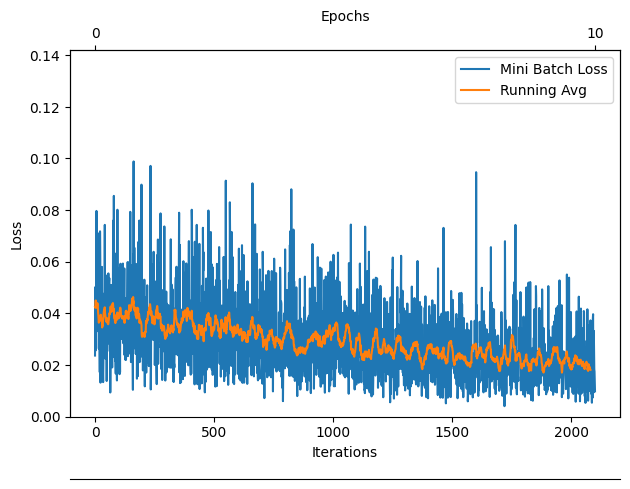

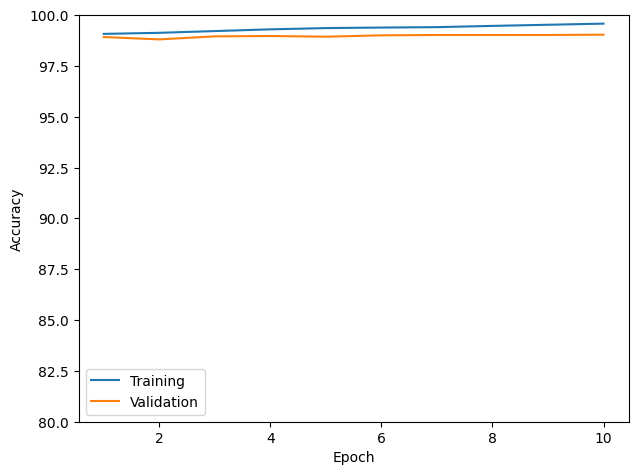

In [31]:
plotTrainingLoss(miniBatchLoss=miniBatchLossList,
                   numEpoch=numEpochs,
                   iterPerEpoch=len(trainLoader),
                   resultsDir=None,
                   avgIter=20)    #plotTrainingLoss(miniBatchLoss,numEpoch,iterPerEpoch,resultsDir=None,avgIter = 100)
plt.show()
plotAccuracy(trainAccList,validAccList)
plt.ylim([80,100])
plt.show()

## Example Check

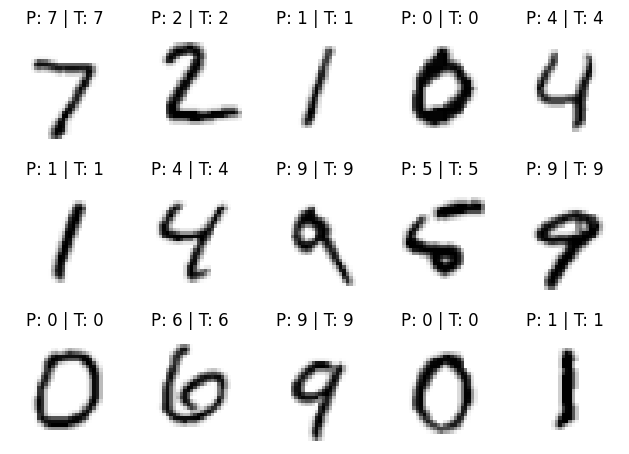

In [32]:
model.cpu()
show_examples(model=model,dataLoader = testLoader)

In [33]:
classDict = {0: '0',
              1: '1',
              2: '2',
              3: '3',
              4: '4',
              5: '5',
              6: '6',
              7: '7',
              8: '8',
              9: '9'}

## Confusion Matrix

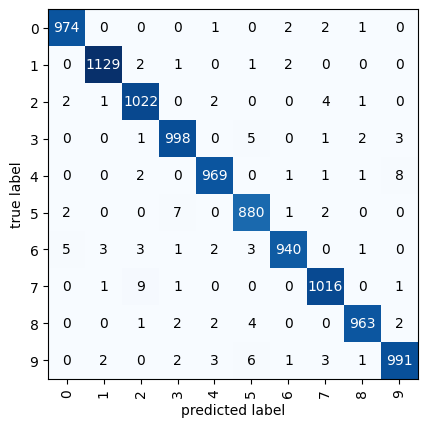

In [34]:
mat = computeConfusionMatrix(model=model, dataLoader=testLoader, device=torch.device('cpu'))
plotConfusionMat(mat, classNames=classDict.values())
plt.show()